In [6]:
import matplotlib.pyplot as plt
import math
import numpy as np
import ROOT, uproot
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import feature_selection
import pandas as pd
import seaborn as sns

# import necessary keras modules/functions
import keras
from keras.models import load_model
from keras.models import Sequential, Model
from keras.layers import Input, Flatten, Dense, Dropout, MaxPooling2D
from keras.layers import BatchNormalization, Activation, AveragePooling2D, Concatenate
from keras import regularizers
import utils, models
from utils import PlotLearning

In [7]:
%jsroot on

In [8]:
events = uproot.open("../FlatTree_Production/Z_Candidates_100k.root")["candidateTree"]
#Print(events.keys())
data = events.arrays(events.keys())

array = []
for i in events.keys():
    array.append(events.array(i))

array = np.array(array)
data = array.T


massMin=50
massMax=130
Z_mass=91.1876

numberOfKeptFeatures=5
numClasses=7

nBins=20
binwidth = ((massMax-massMin)/nBins)
bins = np.array(range(massMin, massMax+binwidth, binwidth))

In [9]:
#Construct measured and truth arrays
x = np.array([i[:-1] for i in data])
y = np.array([i[-1] for i in data])

xNew = [] #Array to hold input data events which migrate by at most one bin.
yNew = [] #Array to hold the migration vector of each event that migrates by at most one bin

#Arrays to hold the mass (reco/gen) of each event that migrates by at most one bin
recoMass = []
genMass = []

#Fill the above arrays with the correct 
for i in range(len(y)): 
    migVec = np.searchsorted(bins, y[i]) - np.searchsorted(bins, x[i][-1])
    if abs(migVec)<(numClasses+1)/2 : 
        xNew.append(x[i])
        recoMass.append(x[i][-1])
        yNew.append(migVec)
        genMass.append(y[i])

df = pd.DataFrame(xNew, columns = events.keys()[:-1])

('Percentage of data that migrates by at most our chosen value:', 98.8818359375)
('Percentage of events that are binned correctly by our initial reconstruction:', 60.45133573650684)
('x_train shape:', (16200, 5))
(16200, 'train samples')
(4051, 'test samples')


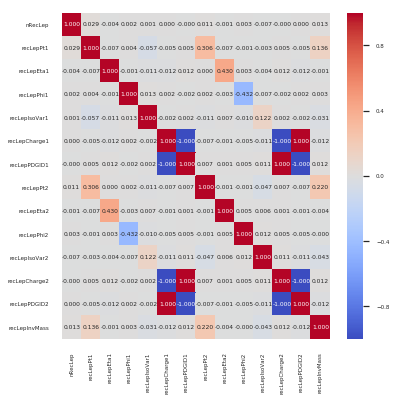

In [10]:
sns.set(rc={'figure.figsize':(6,6)})
sns.set(font_scale=0.5)
fig, ax = plt.subplots()
corr = df.corr(method='pearson')
sns.heatmap(corr, annot=True, fmt='.3f', cmap=plt.get_cmap('coolwarm'), cbar=True, ax=ax)
ax.set_yticklabels(ax.get_yticklabels(), rotation="horizontal")
plt.savefig('result.pdf', bbox_inches='tight', pad_inches=0.0)

xNew = np.array(xNew)
selector = feature_selection.SelectKBest(k=numberOfKeptFeatures).fit(xNew, yNew)
#print(xNew[0])
xNew = selector.transform(xNew)
#print(xNew[0])
#print(selector.scores_)
print('Percentage of data that migrates by at most our chosen value:', float(((xNew.shape[0])) / float(x.shape[0]) )*100)
print('Percentage of events that are binned correctly by our initial reconstruction:', float((yNew.count(0))) / float(len(yNew))*100)

#yNew = np.array([0, 1, 2, 3, -3, -2, -1])
ycat = keras.utils.to_categorical(yNew, np.amax(yNew)-np.amin(yNew)+1) #Turn migration vectors into categories
xNew = preprocessing.scale(xNew)
x_train, x_test, y_train, y_test = train_test_split(xNew, ycat, test_size=0.2, random_state=256)
#y_train, z_train, y_test, z_test= train_test_split(y_train, y_test, test_size=0.5, random_state=256)
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

#for i in range(7):
#    print(i)
#    print(yNew[i])
#    print(ycat[i])

In [11]:
# Define additional callbacks

def reduce_lr(patience_lr):
    reduce_lr_loss = keras.callbacks.ReduceLROnPlateau(monitor='accuracy', factor=0.5, patience=patience_lr, verbose=1, min_delta=1e-4, mode='auto')
    return reduce_lr_loss

callbacks = [reduce_lr(patience_lr=20), PlotLearning(monitor=['loss', 'acc'])]

In [14]:
#sns.set(font_scale=1)
#model = models.ourModel(xNew, numClasses)
#history = model.fit(x_train, y_train, epochs=200, batch_size=1024,  verbose=1, validation_data=(x_test, y_test), callbacks = callbacks)
#model.save("ourModel.hdf5")
model = load_model('ourModel.hdf5')

W0809 12:28:59.806029 139893952362304 deprecation_wrapper.py:119] From /home/aidanwiederhold/.local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0809 12:28:59.817517 139893952362304 deprecation_wrapper.py:119] From /home/aidanwiederhold/.local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0809 12:28:59.829014 139893952362304 deprecation_wrapper.py:119] From /home/aidanwiederhold/.local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0809 12:28:59.852015 139893952362304 deprecation_wrapper.py:119] From /home/aidanwiederhold/.local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:131: The name tf.get_default_graph is deprecated. Please use tf.compa

In [15]:
predictions = model.predict(xNew)
binMigrations = np.zeros(predictions.shape[0])
unfoldedMass = np.zeros(predictions.shape[0])

#Find which category the model says is most likely to be correct for each event
for i in range(predictions.shape[0]):
    binMigrations[i] = np.where(predictions[i] == np.amax(predictions[i]))[0]

#Convert the category to a migration vector
for i in range(len(binMigrations)):
    if(binMigrations[i]>(numClasses-1)/2):
        binMigrations[i]=binMigrations[i]-numClasses-1

unfoldedHisto = ROOT.TH1F("unfoldedHisto", "unfoldedHisto", len(bins)-1, np.array(bins, dtype=float))
genHisto = utils.array2TH1F(genMass, bins, name="genHisto", title="genHisto")
recoHisto = utils.array2TH1F(recoMass, bins, name="recHisto", title="recHisto")

#For each event add 1 entry to the bin predicted by the model
for i in range(len(binMigrations)):
    unfoldedMass[i] = binMigrations[i] + np.searchsorted(bins, recoMass[i])
    unfoldedHisto.AddBinContent(int(unfoldedMass[i]))

canvas = ROOT.TCanvas("canvas", "canvas", 500, 500)
recoHisto.SetLineColor(ROOT.kGreen)
genHisto.SetLineColor(ROOT.kRed)
unfoldedHisto.Draw("hist")
genHisto.Draw("same")
recoHisto.Draw("same")
canvas.BuildLegend()
canvas.Draw()

In [16]:
unfoldedAccuracy = 0
unfoldedCounter = 0
for i in range(len(bins)-1):
    if genHisto.GetBinContent(i) > 0:
        unfoldedAccuracy += ((genHisto.GetBinContent(i) - unfoldedHisto.GetBinContent(i))**2)
        unfoldedCounter +=1
unfoldedAccuracy = math.sqrt(unfoldedAccuracy)/(unfoldedCounter)

recoAccuracy = 0
recoCounter = 0
for i in range(len(bins)-1):
    if genHisto.GetBinContent(i) > 0:
        recoAccuracy += ((genHisto.GetBinContent(i) - recoHisto.GetBinContent(i))**2)
        recoCounter +=1
recoAccuracy = math.sqrt(recoAccuracy)/(recoCounter)

print("Unfolded mass mse", unfoldedAccuracy)
print("Reconstructed mass mse", recoAccuracy)
print("Reconstructed mass mse/ Unfolded mass mse", recoAccuracy/unfoldedAccuracy)

('Unfolded mass mse', 56.708181960230114)
('Reconstructed mass mse', 264.44057536852125)
('Reconstructed mass mse/ Unfolded mass mse', 4.663182035248026)


In [14]:
matrix_histo = ROOT.TH2F("Matrix Histogram", "Generated Z-->l+ l- Invariant Mass; Generated Invariant Mass [GeV]; Reconstructed Invariant Mass [GeV]", nBins, massMin, massMax, nBins, massMin, massMax);
for  i in range(len(recoMass)):
    matrix_histo.Fill(genMass[i], recoMass[i])
    
matrix_canvas = ROOT.TCanvas("matrix canvas", "canvas title", 500, 500)
matrix_histo.SetStats(0);
matrix_canvas.SetRightMargin(0.15);
matrix_canvas.SetLeftMargin(0.15);
matrix_canvas.SetBottomMargin(0.15);
matrix_histo.Draw("COLZ");
matrix_canvas.Draw("HIST");

In [20]:
%%cpp
#include <TError.h>
#include <TMath.h>
#include <TCanvas.h>
#include <TRandom3.h>
#include <TFitter.h>
#include <TF1.h>
#include <TStyle.h>
#include <TVector.h>
#include <TGraph.h>
TUnfold unfold(matrix_histo,TUnfold::kHistMapOutputHoriz,TUnfold::kRegModeSize);
unfold.SetInput(train_detected_histo);
Int_t nScan=50;
Int_t iBest;
Double_t tauMin=1.E-8;
Double_t tauMax=1.E-2;
TSpline *logTauX,*logTauY;
TGraph *lCurve;
iBest=unfold.ScanLcurve(nScan,tauMin,tauMax,&lCurve,&logTauX,&logTauY);
Double_t tau=unfold.GetTau();
unfold.DoUnfold(tau);
TH1D *unfolded=new TH1D("Unfolded",";mass(gen)",nBinsOut,xmin, xmax);
unfold.GetOutput(unfolded);

input_line_56:11:8: error: expected ';' after expression
TUnfold unfold(matrix_histo,TUnfold::kHistMapOutputHoriz,TUnfold::kRegModeSize);
       ^
       ;
input_line_56:11:16: error: use of undeclared identifier 'matrix_histo'
TUnfold unfold(matrix_histo,TUnfold::kHistMapOutputHoriz,TUnfold::kRegModeSize);
               ^
input_line_56:11:29: error: use of undeclared identifier 'TUnfold'
TUnfold unfold(matrix_histo,TUnfold::kHistMapOutputHoriz,TUnfold::kRegModeSize);
                            ^
input_line_56:11:58: error: use of undeclared identifier 'TUnfold'
TUnfold unfold(matrix_histo,TUnfold::kHistMapOutputHoriz,TUnfold::kRegModeSize);
                                                         ^
input_line_56:12:1: error: use of undeclared identifier 'unfold'
unfold.SetInput(train_detected_histo);
^
input_line_56:12:17: error: use of undeclared identifier 'train_detected_histo'
unfold.SetInput(train_detected_histo);
                ^
input_line_56:19:7: error: use of undeclared i

In [22]:
from ROOT import TFile, TTree
from array import array
 
h = ROOT.TH1F( 'h1', 'test', 100, -10., 10. )
 
f = ROOT.TFile( 'test.root', 'recreate' )
t = ROOT.TTree( 't1', 'tree with histos' )
 
maxn = 10
n = array( 'i', [ 0 ] )
d = array( 'f', maxn*[ 0. ] )
t.Branch( 'mynum', n, 'mynum/I' )
t.Branch( 'myval', d, 'myval[mynum]/F' )
 
for i in range(25):
   n[0] = min(i,maxn)
   for j in range(n[0]):
      d[j] = i*0.1+j
   t.Fill()
 
f.Write()
f.Close()